In [1]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from graphcpp.dataset import load_dataset_cpp
from graphcpp.lightning import GraphCPPModule
import seaborn as sns
import numpy as np
sns.set_theme()

%matplotlib inline

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
train = load_dataset_cpp('dataset', split='train')
val = load_dataset_cpp('dataset', split='val')
test = load_dataset_cpp('dataset', split='test')
dataset = list()
for data in train: dataset.append(data)
for data in val: dataset.append(data)
for data in test: dataset.append(data)
labels = [data.y.numpy()[0] for data in dataset]

dataloader = DataLoader(dataset, batch_size=1)

model = GraphCPPModule.load_from_checkpoint(checkpoint_path="model/epoch=38-step=7020.ckpt").model
model.eval();

# Embedding without training

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


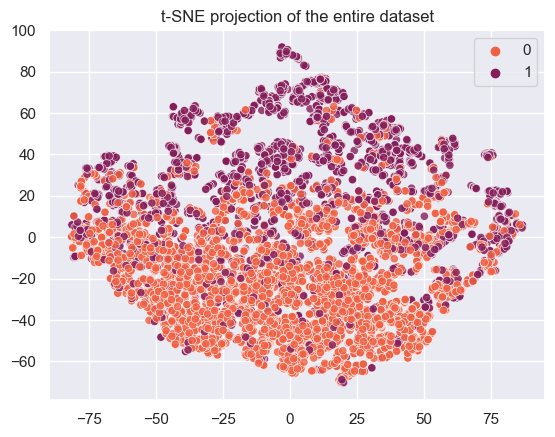

In [10]:
# 1. Pooling or aggregating node features
def mean_pooling(graph):
    return torch.mean(graph.x, dim=0)
def add_pooling(graph):
    return torch.add(graph.x, dim=0)

# Global Attention Pooling
class GraphGlobalAttention(nn.Module):
    def __init__(self, node_feature_dim, attention_dim):
        super(GraphGlobalAttention, self).__init__()
        self.attention = gnn.aggr.AttentionalAggregation(gate_nn=nn.Linear(node_feature_dim, 1), nn=nn.Linear(node_feature_dim, attention_dim))

    def forward(self, x):
        # Graph should be a torch_geometric.data.Data object
        return self.attention(x)

global_attention_model = GraphGlobalAttention(node_feature_dim=32, attention_dim=256)

graph_representations = []

for graph in dataset:
    pooled_features = mean_pooling(graph)
    # pooled_features = global_attention_model(graph.x).squeeze(0)
    graph_representations.append(pooled_features)

# 2. Stack the graph representations
graph_representations = torch.stack(graph_representations)

# 3. Apply t-SNE
tsne = TSNE(n_components=2,
    perplexity=30,
    # init="pca",
    # n_iter=10000,
    random_state=42)
embedded_graphs = tsne.fit_transform(graph_representations.detach().numpy())

# Visualize the t-SNE results
sns.scatterplot(x=embedded_graphs[:, 0], y=embedded_graphs[:, 1], hue=labels, alpha=0.8, palette=sns.color_palette("rocket_r", 2), data=embedded_graphs).set(title="t-SNE projection of the entire dataset") 
plt.savefig('assets/before_tsne.png', dpi=300)
plt.savefig('assets/before_tsne.pdf', dpi=300)
plt.savefig('assets/before_tsne.eps', dpi=300)

# Embedding after training

In [4]:
embeddings = list()
with torch.no_grad():
    for data in dataloader:
        pred, label, embedding = model(data)
        embeddings.append(embedding.squeeze(0).numpy())

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


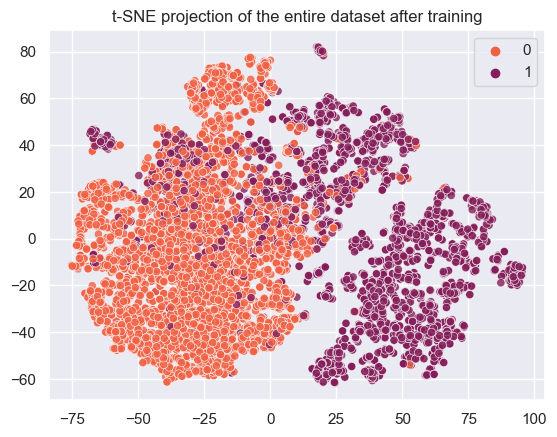

In [9]:
# final_embedding = model_value[2].squeeze(0).numpy()
X = np.array(embeddings)

tsne = TSNE(n_components=2,
    perplexity=30,
    # init="pca",
    # n_iter=10000,
    random_state=42)
embedded_graphs = tsne.fit_transform(X)

sns.scatterplot(x=embedded_graphs[:, 0], y=embedded_graphs[:, 1], hue=labels, alpha=0.8, palette=sns.color_palette("rocket_r", 2), data=embedded_graphs).set(title="t-SNE projection of the entire dataset after training") 
plt.savefig('assets/after_tsne.png', dpi=300)
plt.savefig('assets/after_tsne.pdf', dpi=300)
plt.savefig('assets/after_tsne.eps', dpi=300)